In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices

from pkg_resources import resource_filename
from tradingplatformpoc.generate_mock_data import create_inputs_df

DATA_PATH = 'tradingplatformpoc.data'

In [2]:
df_inputs, df_irrd = create_inputs_df(resource_filename(DATA_PATH, 'temperature_vetelangden.csv'),
                                        resource_filename(DATA_PATH, 'varberg_irradiation_W_m2_h.csv'),
                                        resource_filename(DATA_PATH, 'vetelangden_slim.csv'))
df = df_inputs.to_pandas()

In [3]:
print('columns:', list(df.columns))

columns: ['datetime', 'temperature', 'irradiation', 'hour_of_day', 'day_of_week', 'day_of_month', 'month_of_year', 'major_holiday', 'pre_major_holiday', 'rad_energy', 'hw_energy']


Extract additional features

In [4]:
# Make categorical columns categorical
for key in ['hour_of_day', 'day_of_week', 'day_of_month', 'month_of_year', 'major_holiday', 'pre_major_holiday']:
    df[key] = pd.Categorical(df[key])

# Add seasons column
seasons = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'autumn', 'autumn', 'autumn', 'winter']
month_to_season = dict(zip(range(1,13), seasons))
df['season'] = pd.Categorical(df['month_of_year'].map(month_to_season))

# Try out other combinations of months
comb_months = ['octtoapr', 'octtoapr', 'octtoapr', 'octtoapr', 'mayandsep', 'junetoaug', 'junetoaug', 'junetoaug', 'mayandsep', 'octtoapr', 'octtoapr', 'octtoapr']
month_to_comb = dict(zip(range(1,13), comb_months))
df['comb_month'] = pd.Categorical(df['month_of_year'].map(month_to_comb))

# Try thresholding on temperature
df['temperature_above_threshold'] = pd.Categorical(df['temperature'] > 18.0)

# Try day/night bool
df['night'] = pd.Categorical(df['hour_of_day'].isin(list(range(6,23))))

In [5]:
df.corr()

,temperature,irradiation,rad_energy,hw_energy
temperature,1.000000,0.525668,-0.888995,-0.047828
irradiation,0.525668,1.000000,-0.415893,-0.039996
rad_energy,-0.888995,-0.415893,1.000000,0.017352
hw_energy,-0.047828,-0.039996,0.017352,1.000000


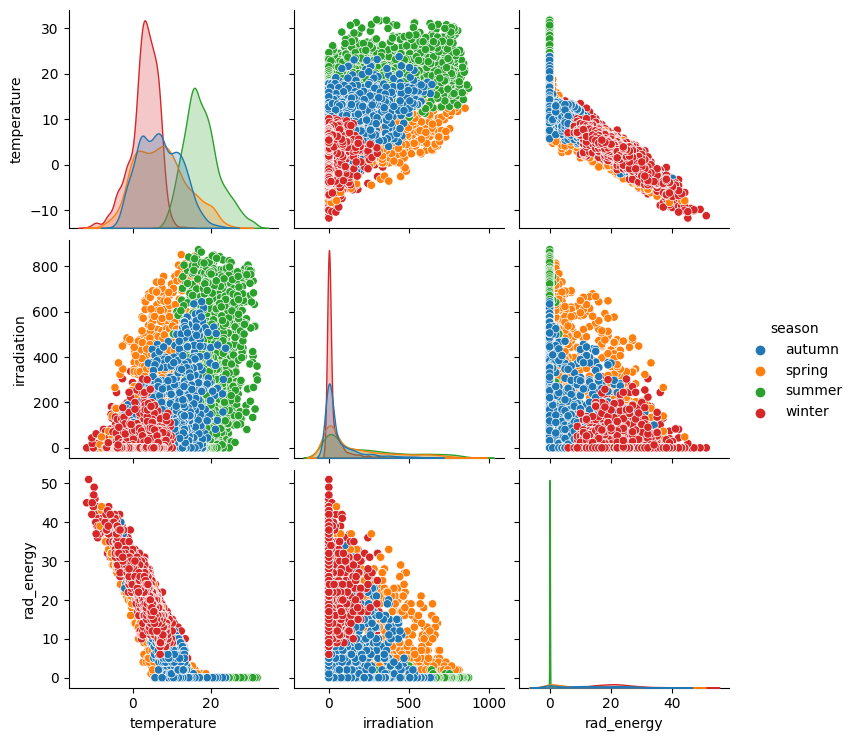

In [6]:
# Pairplots
sns.pairplot(df[['temperature', 'irradiation', 'rad_energy', 'season']], hue='season')

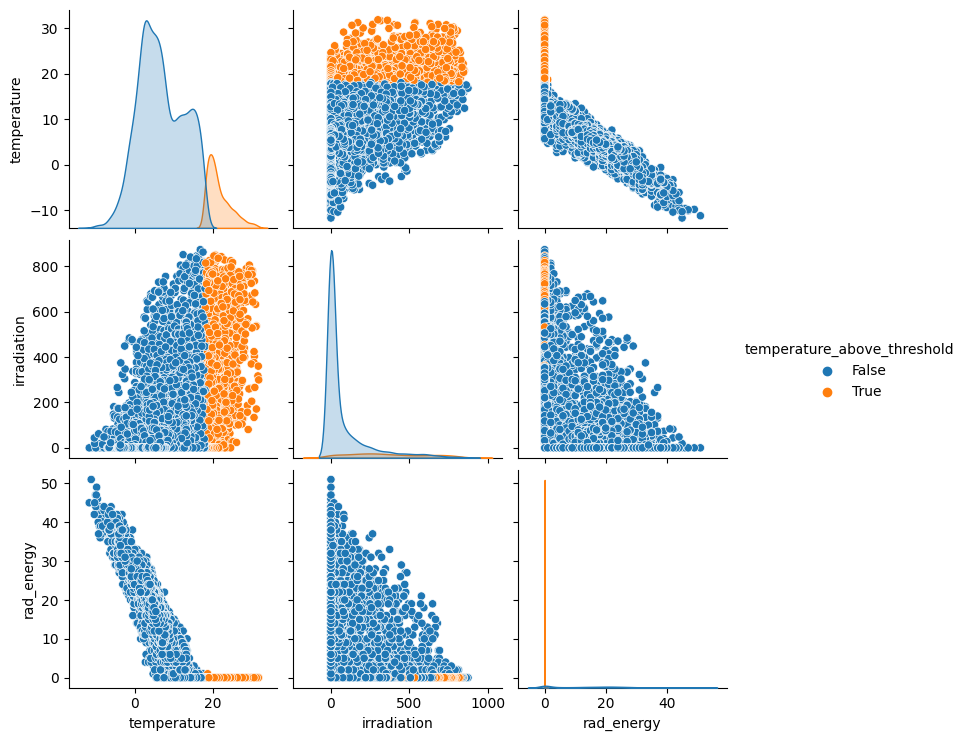

In [7]:
sns.pairplot(df[['temperature', 'irradiation', 'rad_energy', 'temperature_above_threshold']], hue='temperature_above_threshold')

Split data

In [8]:
# Spliting in time since data is sequencial
import numpy as np
np.random.seed(seed=123)

data = df.dropna()
a = 0.7
mask = np.random.rand(len(data.index)) < a
data_train = data[mask]
data_test = data[~mask]

Plot

In [9]:
def plot_rad_energy(dat: pd.DataFrame, pred: pd.Series, hue: pd.Series):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.scatterplot(dat, x='temperature', y='rad_energy', alpha=0.2, hue=hue, legend=False)
    sns.lineplot(x=dat['temperature'], y=pred, hue=hue)
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Radiation energy')

Fit models

In [10]:
# model = smf.ols(formula="rad_energy ~ temperature * season + temperature * temperature_above_threshold", data=data_train).fit()
m_temp_season_interact = smf.ols(formula="rad_energy ~ temperature * season", data=data_train).fit()
m_temp_season_interact.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rad_energy   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     8860.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:34:46   Log-Likelihood:                -16997.
No. Observations:                6387   AIC:                         3.401e+04
Df Residuals:                    6379   BIC:                         3.406e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       25.3457      0.145    174.255      0.000      25.061      25.631
season[T.spring]                -4.3766      0.197    -22.211      0.000      -4.763      -3.990
season[T.summer]               -24.8955      0.385    -64.627      0.000     -25.651     -24.140
season[T.winter]                 1.8584      0.180     10.302      0.000       1.505       2.212
temperature                     -1.7805      0.017   -106.057      0.000      -1.813      -1.748
temperature:season[T.spring]     0.3346      0.022     15.433      0.000       0.292       0.377
temperature:season[T.summer]     1.7584      0.026     67.977      0.000       1.708       1.809
temperature:season[T.winter]     0.0239      0.029      0.828      0.407      -0.033       0.080
==============================================================================
Omnibus:                      282.597   Durbin-Watson:                   0.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              892.699
Skew:                          -0.120   Prob(JB):                    1.42e-194
Kurtosis:                       4.816   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

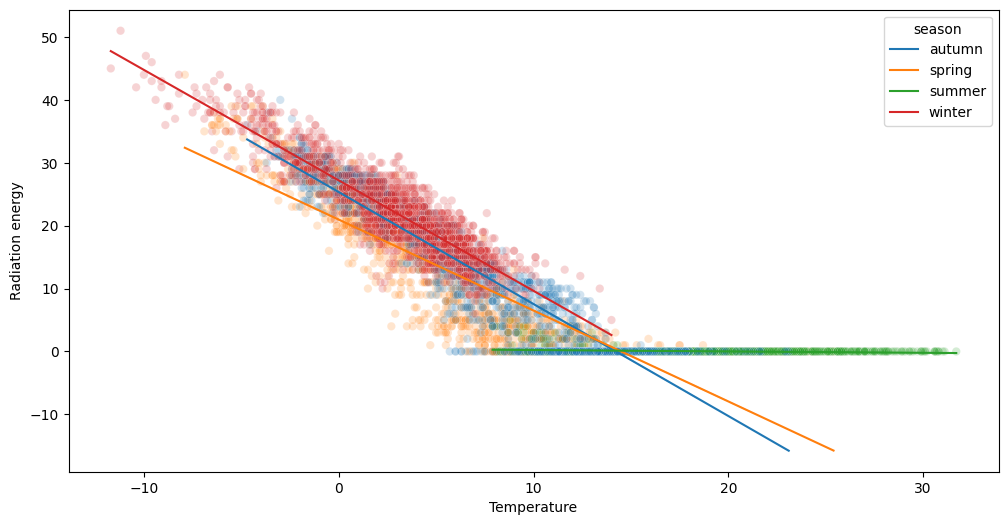

In [11]:
plot_rad_energy(data_train, m_temp_season_interact.predict(), data_train['season'])

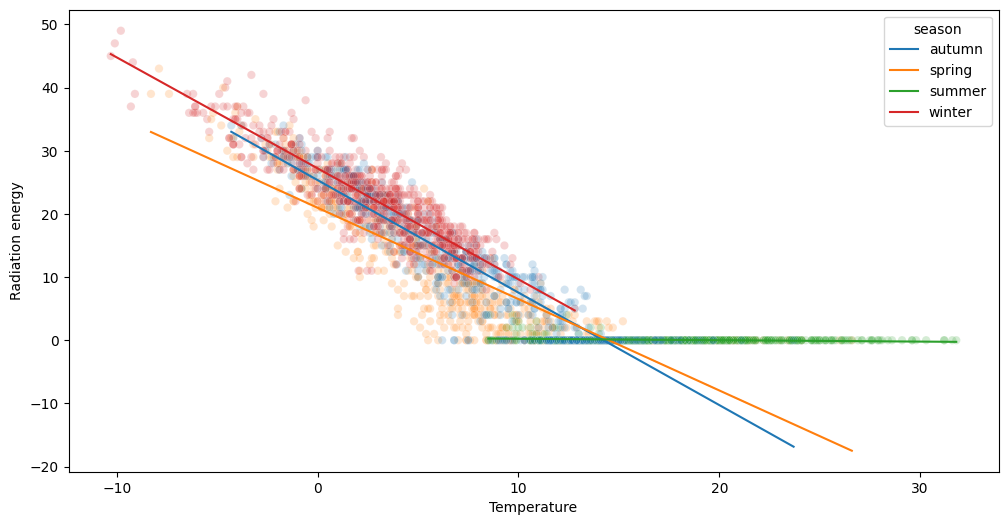

In [12]:
m_temp_season_interact_pred_new = m_temp_season_interact.predict(data_test.drop(columns=['rad_energy']))
plot_rad_energy(data_test, m_temp_season_interact_pred_new, data_test['season'])

<Axes: xlabel='temperature'>

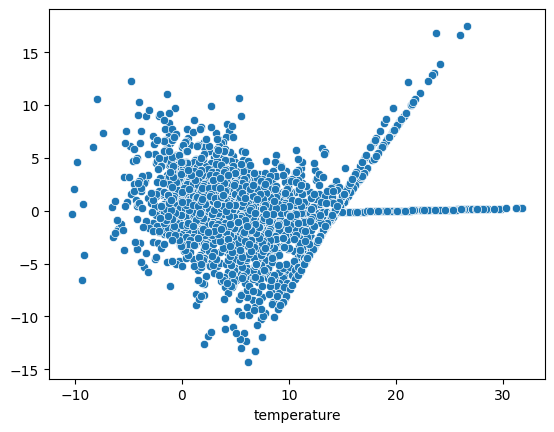

In [13]:
sns.scatterplot(x=data_test['temperature'], y=(data_test['rad_energy'] - m_temp_season_interact_pred_new))  # pred_new.clip(lower=0)

In [14]:
# model = smf.ols(formula="rad_energy ~ temperature * season + temperature * temperature_above_threshold", data=data_train).fit()
m_temp_month_interact = smf.ols(formula="rad_energy ~ temperature * month_of_year", data=data_train).fit()
m_temp_month_interact.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rad_energy   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     4720.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:35:31   Log-Likelihood:                -15332.
No. Observations:                6387   AIC:                         3.071e+04
Df Residuals:                    6363   BIC:                         3.087e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          26.8331      0.238    112.632      0.000      26.366      27.300
month_of_year[T.2]                  1.4003      0.265      5.279      0.000       0.880       1.920
month_of_year[T.3]                 -2.0663      0.276     -7.484      0.000      -2.608      -1.525
month_of_year[T.4]                 -7.6888      0.304    -25.258      0.000      -8.286      -7.092
month_of_year[T.5]                -15.6859      0.360    -43.607      0.000     -16.391     -14.981
month_of_year[T.6]                -25.4326      0.541    -47.043      0.000     -26.492     -24.373
month_of_year[T.7]                -26.8331      0.487    -55.126      0.000     -27.787     -25.879
month_of_year[T.8]                -26.8331      0.596    -44.992      0.000     -28.002     -25.664
month_of_year[T.9]                -16.8240      0.461    -36.503      0.000     -17.728     -15.921
month_of_year[T.10]                -1.6957      0.336     -5.039      0.000      -2.355      -1.036
month_of_year[T.11]                 0.1272      0.283      0.450      0.653      -0.427       0.681
month_of_year[T.12]                -0.6063      0.275     -2.205      0.027      -1.145      -0.067
temperature                        -1.8128      0.048    -38.053      0.000      -1.906      -1.719
temperature:month_of_year[T.2]      0.1913      0.054      3.543      0.000       0.085       0.297
temperature:month_of_year[T.3]     -0.1635      0.056     -2.928      0.003      -0.273      -0.054
temperature:month_of_year[T.4]      0.5658      0.051     11.152      0.000       0.466       0.665
temperature:month_of_year[T.5]      1.0755      0.053     20.376      0.000       0.972       1.179
temperature:month_of_year[T.6]      1.7438      0.055     31.915      0.000       1.637       1.851
temperature:month_of_year[T.7]      1.8128      0.053     34.233      0.000       1.709       1.917
temperature:month_of_year[T.8]      1.8128      0.057     32.028      0.000       1.702       1.924
temperature:month_of_year[T.9]      1.1419      0.057     20.039      0.000       1.030       1.254
temperature:month_of_year[T.10]     0.1519      0.057      2.650      0.008       0.040       0.264
temperature:month_of_year[T.11]    -0.0701      0.065     -1.085      0.278      -0.197       0.057
temperature:month_of_year[T.12]    -0.1012      0.059     -1.727      0.084      -0.216       0.014
==============================================================================
Omnibus:                      273.011   Durbin-Watson:                   0.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              901.907
Skew:                           0.038   Prob(JB):                    1.42e-196
Kurtosis:                       4.839   Cond. No.                  

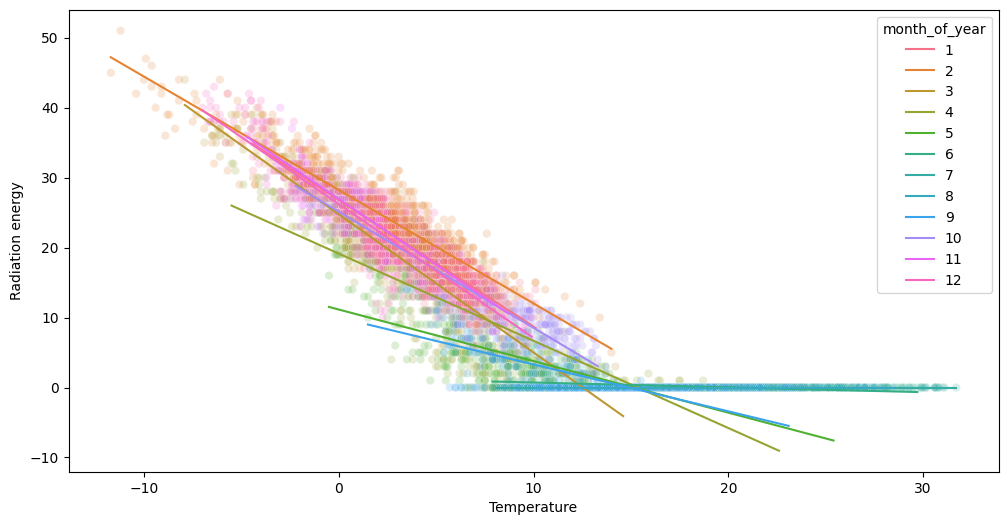

In [15]:
plot_rad_energy(data_train, m_temp_month_interact.predict(), data_train['month_of_year'])

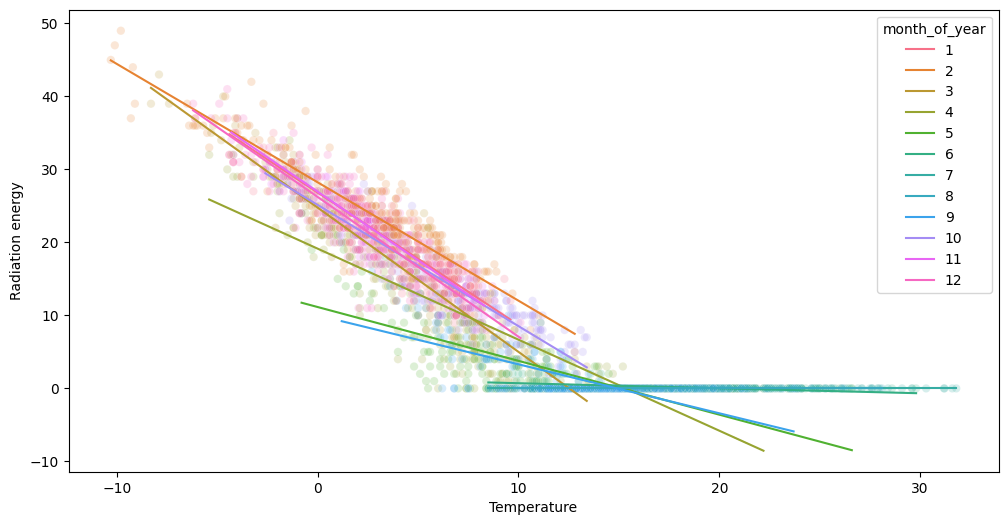

In [16]:
m_temp_month_interact_pred_new = m_temp_month_interact.predict(data_test.drop(columns=['rad_energy']))
plot_rad_energy(data_test, m_temp_month_interact_pred_new, data_test['month_of_year'])

<Axes: xlabel='temperature'>

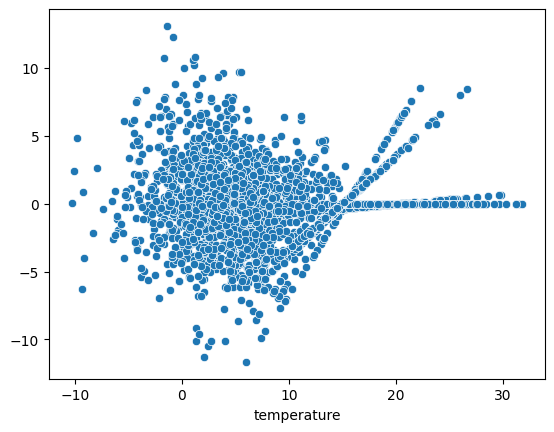

In [18]:
sns.scatterplot(x=data_test['temperature'], y=(data_test['rad_energy'] - m_temp_month_interact_pred_new))

In [19]:
m_temp_comb_month_interact = smf.ols(formula="rad_energy ~ temperature * comb_month", data=data_train).fit()
m_temp_comb_month_interact.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rad_energy   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 1.544e+04
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:36:40   Log-Likelihood:                -16358.
No. Observations:                6387   AIC:                         3.273e+04
Df Residuals:                    6381   BIC:                         3.277e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.4502      0.323      1.395      0.163      -0.182       1.083
comb_month[T.mayandsep]                10.3371      0.415     24.908      0.000       9.524      11.151
comb_month[T.octtoapr]                 25.4641      0.330     77.275      0.000      24.818      26.110
temperature                            -0.0222      0.018     -1.245      0.213      -0.057       0.013
temperature:comb_month[T.mayandsep]    -0.6980      0.028    -25.126      0.000      -0.752      -0.644
temperature:comb_month[T.octtoapr]     -1.7005      0.021    -81.370      0.000      -1.741      -1.659
==============================================================================
Omnibus:                      446.916   Durbin-Watson:                   0.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1557.190
Skew:                          -0.301   Prob(JB):                         0.00
Kurtosis:                       5.343   Cond. No.                         174.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

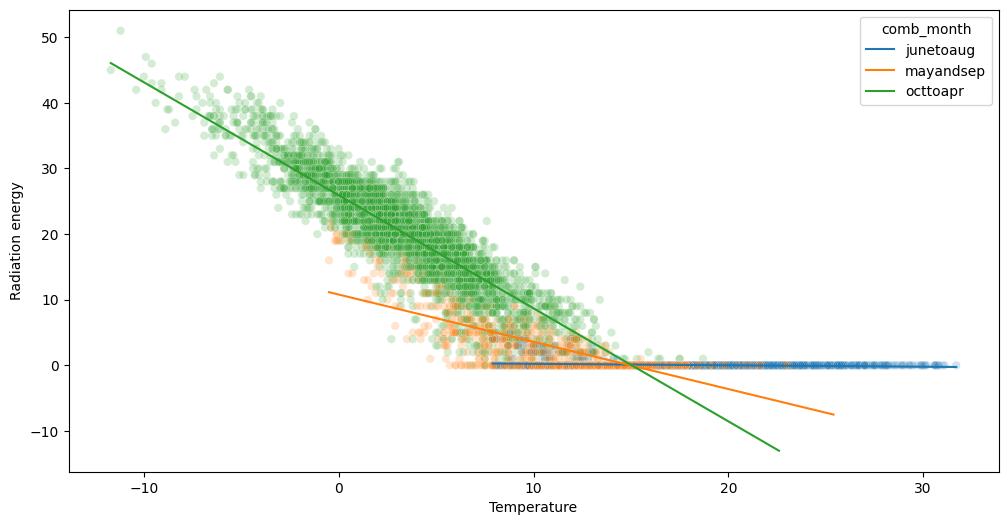

In [20]:
plot_rad_energy(data_train, m_temp_comb_month_interact.predict(), data_train['comb_month'])

<Axes: xlabel='temperature'>

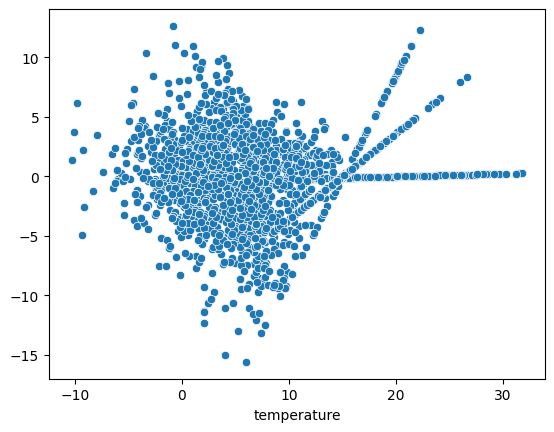

In [21]:
m_temp_comb_month_interact_pred_new = m_temp_comb_month_interact.predict(data_test.drop(columns=['rad_energy']))
sns.scatterplot(x=data_test['temperature'], y=(data_test['rad_energy'] - m_temp_comb_month_interact_pred_new))

In [22]:
m_temp_hour_interact = smf.ols(formula="rad_energy ~ temperature + hour_of_day", data=data_train).fit()
m_temp_hour_interact.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rad_energy   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1084.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:37:09   Log-Likelihood:                -19377.
No. Observations:                6387   AIC:                         3.880e+04
Df Residuals:                    6362   BIC:                         3.897e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.2632      0.312     71.333      0.000      21.651      22.875
hour_of_day[T.2]      0.1002      0.435      0.231      0.818      -0.752       0.952
hour_of_day[T.3]      0.6787      0.437      1.552      0.121      -0.179       1.536
hour_of_day[T.4]      0.2915      0.434      0.671      0.502      -0.560       1.143
hour_of_day[T.5]      1.3805      0.437      3.160      0.002       0.524       2.237
hour_of_day[T.6]      1.7142      0.438      3.917      0.000       0.856       2.572
hour_of_day[T.7]      2.1274      0.432      4.921      0.000       1.280       2.975
hour_of_day[T.8]      2.3597      0.432      5.466      0.000       1.513       3.206
hour_of_day[T.9]      2.6360      0.439      6.001      0.000       1.775       3.497
hour_of_day[T.10]     2.8747      0.430      6.692      0.000       2.033       3.717
hour_of_day[T.11]     2.5704      0.440      5.847      0.000       1.709       3.432
hour_of_day[T.12]     3.0274      0.442      6.851      0.000       2.161       3.894
hour_of_day[T.13]     2.6075      0.436      5.985      0.000       1.753       3.462
hour_of_day[T.14]     2.5142      0.434      5.797      0.000       1.664       3.364
hour_of_day[T.15]     2.7471      0.436      6.297      0.000       1.892       3.602
hour_of_day[T.16]     2.5317      0.438      5.784      0.000       1.674       3.390
hour_of_day[T.17]     2.3035      0.431      5.347      0.000       1.459       3.148
hour_of_day[T.18]     1.3086      0.437      2.995      0.003       0.452       2.165
hour_of_day[T.19]     0.5209      0.439      1.186      0.236      -0.340       1.382
hour_of_day[T.20]    -0.3040      0.438     -0.694      0.488      -1.163       0.555
hour_of_day[T.21]    -0.7303      0.429     -1.701      0.089      -1.572       0.111
hour_of_day[T.22]    -0.9563      0.438     -2.185      0.029      -1.814      -0.098
hour_of_day[T.23]    -0.4890      0.434     -1.127      0.260      -1.340       0.362
hour_of_day[T.24]    -0.1959      0.440     -0.445      0.656      -1.059       0.667
temperature          -1.3907      0.009   -157.996      0.000      -1.408      -1.373
==============================================================================
Omnibus:                       19.007   Durbin-Watson:                   0.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.216
Skew:                           0.020   Prob(JB):                     5.51e-06
Kurtosis:                       3.299   Cond. No.                         274.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
m_temp_night_temp_comb_month_interact = smf.ols(formula="rad_energy ~ temperature * night + temperature * comb_month", data=data_train).fit()
m_temp_night_temp_comb_month_interact.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rad_energy   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.123e+04
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:37:12   Log-Likelihood:                -16304.
No. Observations:                6387   AIC:                         3.262e+04
Df Residuals:                    6379   BIC:                         3.268e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.4755      0.379      6.527      0.000       1.732       3.219
night[T.True]                          -1.1645      0.130     -8.990      0.000      -1.418      -0.911
comb_month[T.mayandsep]                 9.1765      0.433     21.216      0.000       8.329      10.024
comb_month[T.octtoapr]                 24.2085      0.364     66.432      0.000      23.494      24.923
temperature                            -0.2050      0.026     -7.773      0.000      -0.257      -0.153
temperature:night[T.True]               0.1491      0.015     10.233      0.000       0.121       0.178
temperature:comb_month[T.mayandsep]    -0.6355      0.028    -22.437      0.000      -0.691      -0.580
temperature:comb_month[T.octtoapr]     -1.6232      0.023    -71.923      0.000      -1.667      -1.579
==============================================================================
Omnibus:                      457.854   Durbin-Watson:                   0.376
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1511.221
Skew:                          -0.333   Prob(JB):                         0.00
Kurtosis:                       5.288   Cond. No.                         251.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

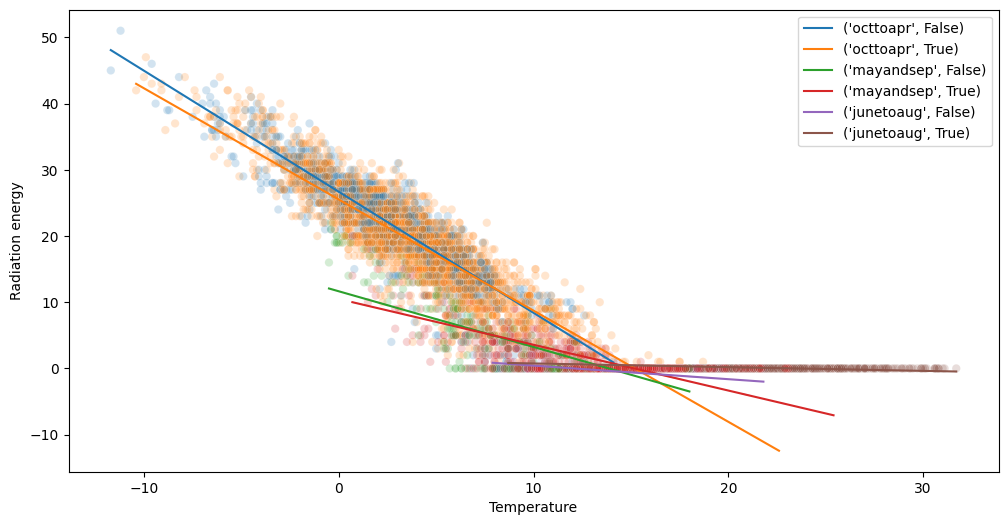

In [24]:
night_comb_month_hue = data_train[['comb_month', 'night']].apply(tuple, axis=1)
plot_rad_energy(data_train, m_temp_night_temp_comb_month_interact.predict(), night_comb_month_hue)